# COHORT ANALYSIS

- Cohort analysis is a type of behavioral analytics that groups users together based on shared characteristics, such as signup date, location, or device type. It then tracks their behavior over time to identify trends and patterns. This information can be used to improve customer retention, product development, and marketing campaigns.

- Cohort analysis is a powerful tool that can be used to gain valuable insights into customer behavior. It can be used by businesses of all sizes and across all industries.

### ADVANTAGES OF COHORT ANALYSIS
- Improved customer retention: Cohort analysis can help businesses to identify which customers are most likely to churn and to develop targeted interventions to improve retention.
- Better product development: Cohort analysis can help businesses to understand how different customer cohorts use their products and to identify areas where improvement is needed.
- More effective marketing campaigns: Cohort analysis can help businesses to segment their customer base and to target their marketing campaigns more effectively.

### WHY COHORT ANALYSIS?
- It helps to understand how the behaviour of users can affect the business in terms of acquisition and retention
- It helps to analyze the customer churn rate
- It also helps in calculating the lifetime value of a customer
- It helps in finding the points where we need to increase more engagement with the customer.

### TYPES OF COHORT ANALYSIS.
### Time cohort
- Time cohorts are customers who have signed up for a product or service during a specified period. Analysis of these cohorts shows the behaviour of customers based on when they started using the company’s products or services. The time can be monthly or quarterly or even daily.
### size cohort
- Behaviour cohorts are customers who have purchased a product or subscribed to service in the past. It groups customers according to the type of product or service to which they have subscribed. Customers who signed up for basic services may have different needs than those who signed up for advanced services. Understanding the needs of different cohorts can help a business design tailor-made services or products for particular segments.
### Behaviour cohort
- Size cohorts refer to the different sizes of customers who purchase the company’s products or services. This categorization can be based on the amount of spend in a certain period after acquisition or the type of product that the customer has spent most of the amount of their order in a given period.

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [8]:
data = pd.read_csv("Online Retail.csv",encoding='unicode_escape')

In [9]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [11]:
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [12]:
data = data.dropna(subset=["CustomerID"])

In [14]:
data.shape

(406829, 8)

In [15]:
data.duplicated().sum()

5225

In [16]:
data = data.drop_duplicates()

In [17]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,401604.000000,401604.000000,401604.000000
mean,12.183273,3.474064,15281.160818
std,250.283037,69.764035,1714.006089
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13939.000000
50%,5.000000,1.950000,15145.000000
75%,12.000000,3.750000,16784.000000
max,80995.000000,38970.000000,18287.000000


- The minmum value of quantity is negative and unit price is 0.

In [18]:
data = data[(data["Quantity"]>0)&(data["UnitPrice"]>0)]

## DATA PREPARING FOR COHORT ANALYSIS
- Billing period: String representation of the year and month of a single transaction/invoice.
- Cohort Group: A string representation of the year and month of a customer’s first purchase. This label is common to all invoices for a particular customer.
- Cohort Period / Cohort Index: Full representation of a client’s stage in their “lifespan”. The number represents the number of months since the first purchase

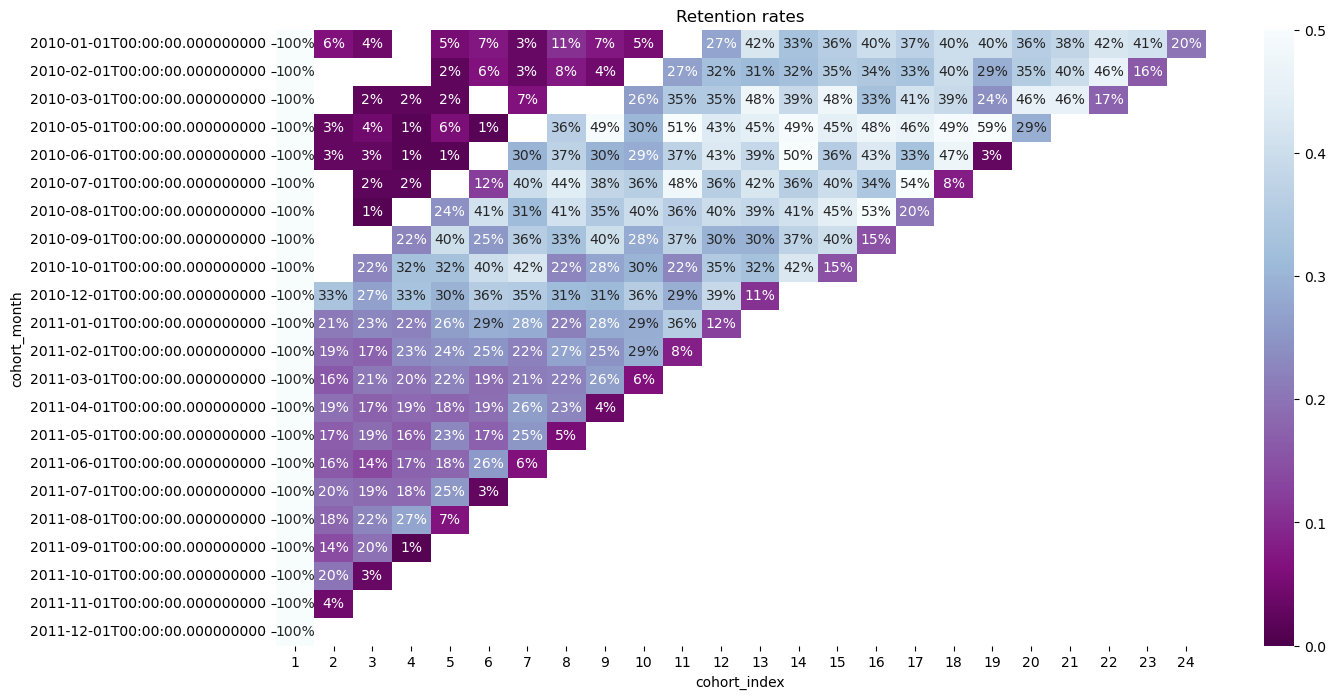

In [33]:
def get_month(x): return dt.datetime(x.year,x.month,1)
data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"])
data["invoice_month"] = data["InvoiceDate"].apply(get_month)
grouping = data.groupby("CustomerID")["invoice_month"]
data["cohort_month"] = grouping.transform("min")

def get_month_int(df,column):
    year=data[column].dt.year
    month=data[column].dt.month
    day=data[column].dt.day
    return year,month,day

invoice_year,invoice_month,_ = get_month_int(data,"invoice_month")
cohort_year, cohort_month,_ = get_month_int(data,"cohort_month")

year_diff = invoice_year - cohort_year
month_diff = invoice_month - cohort_month

data["cohort_index"] = (year_diff*12) + month_diff +1
 
# count monthly active users from each cohort
grouping1 = data.groupby(["cohort_month","cohort_index"])
cohort_data = grouping1["CustomerID"].apply(pd.Series.nunique)

# return number of unique elements in the object
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index="cohort_month",columns="cohort_index",values="CustomerID")

# Retention table
cohort_size = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_size,axis=0) #axis=0 to ensure the divide along the row axis 
retention.round(3) * 100 #to show the number as percentage

#Build the heatmap
plt.figure(figsize=(15, 8))
plt.title('Retention rates')
sns.heatmap(data=retention,annot = True,fmt = '.0%',vmin = 0.0,vmax = 0.5,cmap="BuPu_r")
plt.show()



- Customer retention is a very useful metric to understand how many of all customers are still active. Loyalty gives you the percentage of active customers compared to the total number of customers.

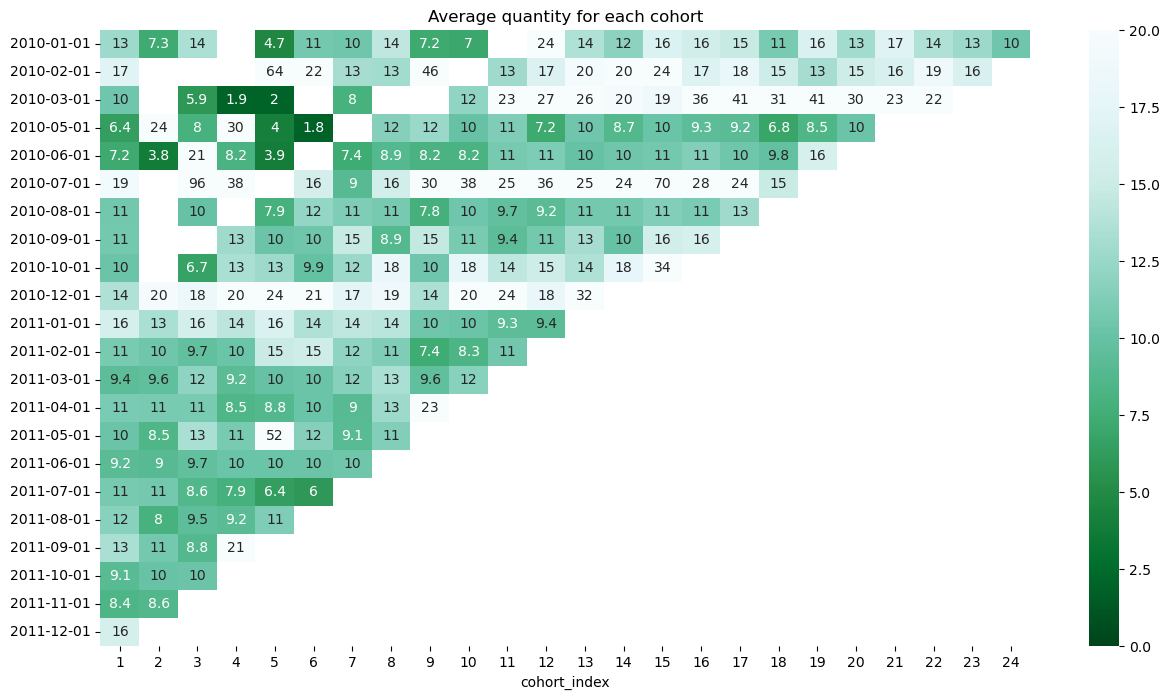

In [40]:
grouping2 = data.groupby(["cohort_month", "cohort_index"])
cohort_data2 = grouping2["Quantity"].mean()
cohort_data2 = cohort_data2.reset_index()
avg_quantity = cohort_data2.pivot(index="cohort_month",columns="cohort_index", values="Quantity")
avg_quantity = avg_quantity.round(1)
avg_quantity.index = avg_quantity.index.date

#Build the heatmap
plt.figure(figsize=(15, 8))
plt.title('Average quantity for each cohort')
sns.heatmap(data=avg_quantity,annot = True,vmin = 0.0,vmax =20,cmap="BuGn_r")
plt.show()

- The average quantity is usefull to understand the quqntity of purchase of each cohort.